# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from tqdm import tqdm
import torch.nn.functional as F

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle

import gc

import matplotlib.pyplot as plt

# Functions

In [2]:
# Data preparation functions

def load_data(path):
    """Load processed data from .npz file"""
    data = dict(np.load(path, allow_pickle=True))
    # data['caption2img'] = data['caption2img'].item()
    # data['caption2img_idx'] = data['caption2img_idx'].item()
    return data

def prepare_train_data(data):
    """Prepare training data from loaded dict"""
    caption_embd = data['captions/embeddings']
    image_embd = data['images/embeddings']
    # Map caption embeddings to corresponding image embeddings
    label = data['captions/label'] # N x M

    # repeat the image embeddings according to the label
    label_idx = np.nonzero(label)[1]
    print(label_idx.shape)
    image_embd = image_embd[label_idx]
    assert caption_embd.shape[0] == image_embd.shape[0], "Mismatch in number of caption and image embeddings"

    X = torch.from_numpy(caption_embd).float()
    # Map each caption to its corresponding image embedding
    y = torch.from_numpy(image_embd).float()
    label = torch.from_numpy(label).bool()

    print(f"Train data: {len(X)} captions, {len(image_embd)} images")
    return X, y, label

def generate_submission(sample_ids, translated_embeddings, output_file="submission.csv"):
    """
    Generate a submission.csv file from translated embeddings.
    """
    print("Generating submission file...")

    if isinstance(translated_embeddings, torch.Tensor):
        translated_embeddings = translated_embeddings.cpu().numpy()

    # Create a DataFrame with sample_id and embeddings

    df_submission = pd.DataFrame({'id': sample_ids, 'embedding': translated_embeddings.tolist()})

    df_submission.to_csv(output_file, index=False, float_format='%.17g')
    print(f"✓ Saved submission to {output_file}")
    
    return df_submission

In [3]:
# model training functions

def train_model(model, train_loader, val_loader, device, epochs, lr, MODEL_PATH):
    """Train the MLP model"""
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)

            loss = F.mse_loss(outputs, y_batch)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = F.mse_loss(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"  ✓ Saved best model (val_loss={val_loss:.6f})")

    return model


In [4]:
def mrr(pred_indices: np.ndarray, gt_indices: np.ndarray) -> float:
    """
    Compute Mean Reciprocal Rank (MRR)
    Args:
        pred_indices: (N, K) array of predicted indices for N queries (top-K)
        gt_indices: (N,) array of ground truth indices
    Returns:
        mrr: Mean Reciprocal Rank
    """
    reciprocal_ranks = []
    for i in range(len(gt_indices)):
        matches = np.where(pred_indices[i] == gt_indices[i])[0]
        if matches.size > 0:
            reciprocal_ranks.append(1.0 / (matches[0] + 1))
        else:
            reciprocal_ranks.append(0.0)
    return np.mean(reciprocal_ranks)


def recall_at_k(pred_indices: np.ndarray, gt_indices: np.ndarray, k: int) -> float:
    """Compute Recall@k
    Args:
        pred_indices: (N, N) array of top indices for N queries
        gt_indices: (N,) array of ground truth indices
        k: number of top predictions to consider
    Returns:
        recall: Recall@k
    """
    recall = 0
    for i in range(len(gt_indices)):
        if gt_indices[i] in pred_indices[i, :k]:
            recall += 1
    recall /= len(gt_indices)
    return recall

import numpy as np

def ndcg(pred_indices: np.ndarray, gt_indices: np.ndarray, k: int = 100) -> float:
    """
    Compute Normalized Discounted Cumulative Gain (NDCG@k)
    Args:
        pred_indices: (N, K) array of predicted indices for N queries
        gt_indices: (N,) array of ground truth indices
        k: number of top predictions to consider
    Returns:
        ndcg: NDCG@k
    """
    ndcg_total = 0.0
    for i in range(len(gt_indices)):
        matches = np.where(pred_indices[i, :k] == gt_indices[i])[0]
        if matches.size > 0:
            rank = matches[0] + 1
            ndcg_total += 1.0 / np.log2(rank + 1)  # DCG (IDCG = 1)
    return ndcg_total / len(gt_indices)



@torch.inference_mode()
def evaluate_retrieval(translated_embd, image_embd, gt_indices, max_indices = 99, batch_size=100):
    """Evaluate retrieval performance using cosine similarity
    Args:
        translated_embd: (N_captions, D) translated caption embeddings
        image_embd: (N_images, D) image embeddings
        gt_indices: (N_captions,) ground truth image indices for each caption
        max_indices: number of top predictions to consider
    Returns:
        results: dict of evaluation metrics
    
    """
    # Compute similarity matrix
    if isinstance(translated_embd, np.ndarray):
        translated_embd = torch.from_numpy(translated_embd).float()
    if isinstance(image_embd, np.ndarray):
        image_embd = torch.from_numpy(image_embd).float()
    
    n_queries = translated_embd.shape[0]
    device = translated_embd.device
    
    # Prepare containers for the fragments to be reassembled
    all_sorted_indices = []
    l2_distances = []
    
    # Process in batches - the narrow gate approach
    for start_idx in range(0, n_queries, batch_size):
        batch_slice = slice(start_idx, min(start_idx + batch_size, n_queries))
        batch_translated = translated_embd[batch_slice]
        batch_img_embd = image_embd[batch_slice]
        
        # Compute similarity only for this batch
        batch_similarity = batch_translated @ batch_img_embd.T

        # Get top-k predictions for this batch
        batch_indices = batch_similarity.topk(k=max_indices, dim=1, sorted=True).indices.numpy()
        all_sorted_indices.append(gt_indices[batch_slice][batch_indices])

        # Compute L2 distance for this batch
        batch_gt = gt_indices[batch_slice]
        batch_gt_embeddings = image_embd[batch_gt]
        batch_l2 = (batch_translated - batch_gt_embeddings).norm(dim=1)
        l2_distances.append(batch_l2)
    
    # Reassemble the fragments
    sorted_indices = np.concatenate(all_sorted_indices, axis=0)
    
    # Apply the sacred metrics to the whole
    metrics = {
        'mrr': mrr,
        'ndcg': ndcg,
        'recall_at_1': lambda preds, gt: recall_at_k(preds, gt, 1),
        'recall_at_3': lambda preds, gt: recall_at_k(preds, gt, 3),
        'recall_at_5': lambda preds, gt: recall_at_k(preds, gt, 5),
        'recall_at_10': lambda preds, gt: recall_at_k(preds, gt, 10),
        'recall_at_50': lambda preds, gt: recall_at_k(preds, gt, 50),
    }
    
    results = {
        name: func(sorted_indices, gt_indices)
        for name, func in metrics.items()
    }
    
    l2_dist = torch.cat(l2_distances, dim=0).mean().item()
    results['l2_dist'] = l2_dist
    
    return results

# Data Preparation

In [ ]:
# load data
train_data = load_data('data/train/train/train.npz')

In [ ]:
# prepare train data
X, y, label = prepare_train_data(train_data)

(125000,)
Train data: 125000 captions, 125000 images


In [ ]:
X.shape, y.shape

(torch.Size([125000, 1024]), torch.Size([125000, 1536]))

In [ ]:
# split into train and val
DATASET_SIZE = len(X)
n_train = int(0.9 * len(X))
TRAIN_SPLIT = torch.zeros(len(X), dtype=torch.bool)
TRAIN_SPLIT[:n_train] = 1
X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]
labels_train, labels_val = label[TRAIN_SPLIT], label[~TRAIN_SPLIT]

X_train.shape, X_val.shape, y_train.shape, y_val.shape, labels_train.shape, labels_val.shape

(torch.Size([112500, 1024]),
 torch.Size([12500, 1024]),
 torch.Size([112500, 1536]),
 torch.Size([12500, 1536]),
 torch.Size([112500, 25000]),
 torch.Size([12500, 25000]))

In [ ]:
del X, y, train_data, label
gc.collect()

117

In [ ]:
# normalize features, min-max scaling
minmax_X = MinMaxScaler(feature_range=(-1, 1))
X_train_norm = minmax_X.fit_transform(X_train)
X_val_norm = minmax_X.transform(X_val)

# normalize targets, min-max scaling
minmax_y = MinMaxScaler(feature_range=(-1, 1))
y_train_norm = minmax_y.fit_transform(y_train)
y_val_norm = minmax_y.transform(y_val)

In [ ]:
X_train_norm.shape, y_train_norm.shape, X_train.shape, y_train.shape

((112500, 1024),
 (112500, 1536),
 torch.Size([112500, 1024]),
 torch.Size([112500, 1536]))

In [ ]:
# standardize features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

# standardize targets
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)

In [ ]:
# save scalers as a pickle file
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)

with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)


# save min-max normalizers as a pickle files
with open('minmax_X.pkl', 'wb') as f:
    pickle.dump(minmax_X, f)

with open('minmax_y.pkl', 'wb') as f:
    pickle.dump(minmax_y, f)

In [ ]:
# validation label indices
img_VAL_SPLIT = labels_val.sum(dim=0) > 0
val_label = np.nonzero(labels_val.numpy()[:,img_VAL_SPLIT])[1]

gc.collect()

# train label indices
img_TRAIN_SPLIT = labels_train.sum(dim=0) > 0
train_label = np.nonzero(labels_train.numpy()[:,img_TRAIN_SPLIT])[1]

In [ ]:
gc.collect()

0

In [ ]:
# # save original train/val data and labels
# torch.save({'captions/embeddings': X_train, 'images/embeddings': y_train, 'captions/label': labels_train}, 'data/X_y_labels_train.pt')
# torch.save({'captions/embeddings': X_val, 'images/embeddings': y_val, 'captions/label': labels_val}, 'data/X_y_labels_val.pt')

# save data
torch.save({'captions/embeddings': X_train,
            'captions/embeddings_standartized': torch.from_numpy(X_train_scaled).float(),
            'captions/embeddings_normalized': torch.from_numpy(X_train_norm).float(),
            'images/embeddings': y_train,
            'images/embeddings_standartized': torch.from_numpy(y_train_scaled).float(),
            'images/embeddings_normalized': torch.from_numpy(y_train_norm).float(),
            'captions/label': labels_train,
            'captions/label_indices': torch.from_numpy(train_label).long()}, 'data/X_y_labels_train_scaled.pt')
torch.save({'captions/embeddings': X_val,
            'captions/embeddings_standartized': torch.from_numpy(X_val_scaled).float(),
            'captions/embeddings_normalized': torch.from_numpy(X_val_norm).float(),
            'images/embeddings': y_val,
            'images/embeddings_standartized': torch.from_numpy(y_val_scaled).float(),
            'images/embeddings_normalized': torch.from_numpy(y_val_norm).float(),
            'captions/label': labels_val,
            'captions/label_indices': torch.from_numpy(val_label).long()}, 'data/X_y_labels_val_scaled.pt')

# Read Data Back

In [5]:
# read scaled data back
train = torch.load('data/X_y_labels_train_scaled.pt')
val = torch.load('data/X_y_labels_val_scaled.pt')

In [22]:
train

{'captions/embeddings': tensor([[-0.7071, -0.0791, -0.6444,  ...,  0.9438, -1.3346,  0.5247],
         [ 0.3744, -0.6224, -0.5922,  ...,  0.1355, -1.2186,  0.4079],
         [-0.5834, -0.3095, -0.9278,  ..., -0.1768, -0.4095, -0.1322],
         ...,
         [ 0.4443, -0.4923, -0.5300,  ..., -0.3735,  0.5138, -1.0740],
         [ 1.2572, -0.8468, -0.4401,  ...,  0.4742,  0.7457, -0.8515],
         [ 0.3378, -0.8111, -1.1533,  ...,  0.7410,  0.4934,  0.0679]]),
 'captions/embeddings_standartized': tensor([[-1.0484, -0.2398, -1.1937,  ...,  1.9227, -0.8140,  0.6990],
         [ 0.5970, -1.0902, -1.0971,  ...,  0.5235, -0.6814,  0.5296],
         [-0.8602, -0.6004, -1.7190,  ..., -0.0170,  0.2435, -0.2536],
         ...,
         [ 0.7032, -0.8866, -0.9816,  ..., -0.3574,  1.2990, -1.6193],
         [ 1.9398, -1.4414, -0.8151,  ...,  1.1098,  1.5640, -1.2967],
         [ 0.5412, -1.3856, -2.1370,  ...,  1.5716,  1.2756,  0.0366]]),
 'captions/embeddings_normalized': tensor([[-3.2244e-01, 

In [6]:
X_train_scaled = train['captions/embeddings_standartized']
y_train_scaled = train['images/embeddings_standartized']
# X_train_norm = train['captions/embeddings_normalized']
# y_train_norm = train['images/embeddings_normalized']
X_train = train['captions/embeddings']
labels_train = train['captions/label']
labels_train_indices = train['captions/label_indices']
y_train = train['images/embeddings']


X_val_scaled = val['captions/embeddings_standartized']
y_val_scaled = val['images/embeddings_standartized']
# X_val_norm = val['captions/embeddings_normalized']
# y_val_norm = val['images/embeddings_normalized']
X_val = val['captions/embeddings']
labels_val = val['captions/label']
labels_val_indices = val['captions/label_indices']
y_val = val['images/embeddings']

In [26]:
labels_train_indices.shape, labels_val_indices.shape

(torch.Size([112500]), torch.Size([12500]))

In [27]:
112500/5

22500.0

In [10]:
# X_train_norm.shape, y_train_norm.shape, 
X_train_scaled.shape, y_train_scaled.shape, X_train.shape, y_train.shape, labels_train.shape, labels_val.shape, labels_train_indices.shape, labels_val_indices.shape

(torch.Size([112500, 1024]),
 torch.Size([112500, 1536]),
 torch.Size([112500, 1024]),
 torch.Size([112500, 1536]),
 torch.Size([112500, 25000]),
 torch.Size([12500, 25000]),
 torch.Size([112500]),
 torch.Size([12500]))

In [20]:
y_train_scaled.shape

torch.Size([112500, 1536])

In [21]:
torch.unique(y_train_scaled, dim=0).shape

torch.Size([22499, 1536])

In [22]:
y_val_scaled.shape

torch.Size([12500, 1536])

In [23]:
torch.unique(y_val_scaled, dim=0).shape

torch.Size([2500, 1536])

In [9]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

class UniquePairDataset(Dataset):
    """
    A custom PyTorch Dataset that ensures each batch contains unique 1-to-1
    (caption, image) pairs.
    
    For each epoch, it randomly samples ONE of the 5 captions for each 
    of the 25,000 unique images.
    """
    
    def __init__(self, captions_emb, images_emb, mapping_matrix):
        """
        Initializes the dataset.
        
        Args:
            captions_emb (np.ndarray): The (N, 1024) caption embeddings.
            images_emb (np.ndarray): The (N, 1536) unique image embeddings.
            mapping_matrix (np.ndarray): The (N, 25000) boolean mapping.
        """
        
        # Store data as tensors
        self.captions = torch.from_numpy(captions_emb).float()
        self.images = torch.from_numpy(images_emb).float()
        
        # --- Pre-process the mapping ---
        # We want a fast way to find "which captions match image j?"
        
        # Transpose mapping to (25000, N)
        mapping_T = mapping_matrix.T 
        
        # This list will hold 25,000 arrays
        self.image_to_captions_map = []
        
        print("Pre-building image-to-caption map...")
        for j in range(len(self.images)):
            # Find all caption indices 'i' that map to this image 'j'
            matching_caption_indices = np.where(mapping_T[j] == True)[0]
            self.image_to_captions_map.append(matching_caption_indices)
        
        print("Dataset ready.")

    def __len__(self):
        """Returns the length of the dataset (the number of unique images)."""
        # We have 25,000 unique images
        return len(self.images)

    def __getitem__(self, idx):
        """
        Returns one random (caption, image) pair.
        'idx' is the image index (0 to 24999).
        """
        
        # 1. Get the image embedding (this is the easy part)
        image_embedding = self.images[idx]
        
        # 2. Find all 5 captions for this image
        possible_caption_indices = self.image_to_captions_map[idx]
        
        # 3. Randomly pick ONE of those 5 captions
        chosen_caption_index = np.random.choice(possible_caption_indices)
        
        # 4. Get the corresponding caption embedding
        caption_embedding = self.captions[chosen_caption_index]
        
        return caption_embedding, image_embedding

In [10]:
# # --- 1. Load your data (as NumPy arrays) ---
# # (You already have this)
# X_train = data['captions/embeddings']
# y_train = data['images/embeddings'] # The (25000, 1536) unique images
# train_mapping = data['captions/label'] # The (125000, 25000) mapping

# # (Repeat for validation data...)
# X_val = ...
# y_val = ...
# val_mapping = ...

# --- 2. Create the new Datasets ---
# Use your SCALED data here
train_dataset = UniquePairDataset(X_train_scaled.numpy(), torch.unique(y_train_scaled, dim=0).numpy(), labels_train.numpy())
val_dataset = UniquePairDataset(X_val_scaled.numpy(), torch.unique(y_val_scaled, dim=0).numpy(), labels_val.numpy())

# --- 3. Create your DataLoaders ---
# This will now be perfect for contrastive loss
train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True, # Shuffles the 25,000 images
    num_workers=2, # Optional, for faster loading
    pin_memory=True # Optional, for faster loading
)

val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=False, # No need to shuffle validation
    num_workers=2,
    pin_memory=True
)

# --- 4. Train your model ---
# Your 'train_model' function with contrastive loss will now
# work perfectly. It will get batches of unique (caption, image) pairs.
# model = train_model(...)

Pre-building image-to-caption map...
Dataset ready.
Pre-building image-to-caption map...
Dataset ready.


In [ ]:
train_loader_iterator = iter(train_loader)
first_X_batch, first_y_batch = next(train_loader_iterator)

c:\Users\User\.conda\envs\pytorch_env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [12]:
train['images/embeddings_standartized'].shape

torch.Size([112500, 1536])

In [ ]:
del train, val

import gc

gc.collect()

51

In [ ]:
np.argsort(-X_train.mean(axis=0))

tensor([952, 600, 146,  ..., 903, 508, 631])

In [ ]:
np.argsort(-X_train.std(axis=0))

tensor([631,  96, 121,  ..., 845, 539,  70])

In [ ]:
X_train.std(axis=0)[96]

tensor(1.3335)

In [ ]:
-np.sort(-X_train.std(axis=0))

array([3.5675757 , 1.3334981 , 1.2606837 , ..., 0.4316768 , 0.4012041 ,
       0.37122837], dtype=float32)

In [ ]:
-np.sort(-y_train.mean(axis=0))

array([ 5.6693068,  4.446799 ,  4.1355586, ..., -2.8808618, -4.2800045,
       -7.2632155], dtype=float32)

In [ ]:
np.argsort(-y_train.std(axis=0))

tensor([ 170, 1224, 1179,  ..., 1058, 1105, 1223])

In [ ]:
np.argsort(-y_val.std(axis=0))

tensor([ 170, 1224, 1325,  ..., 1058, 1105, 1223])

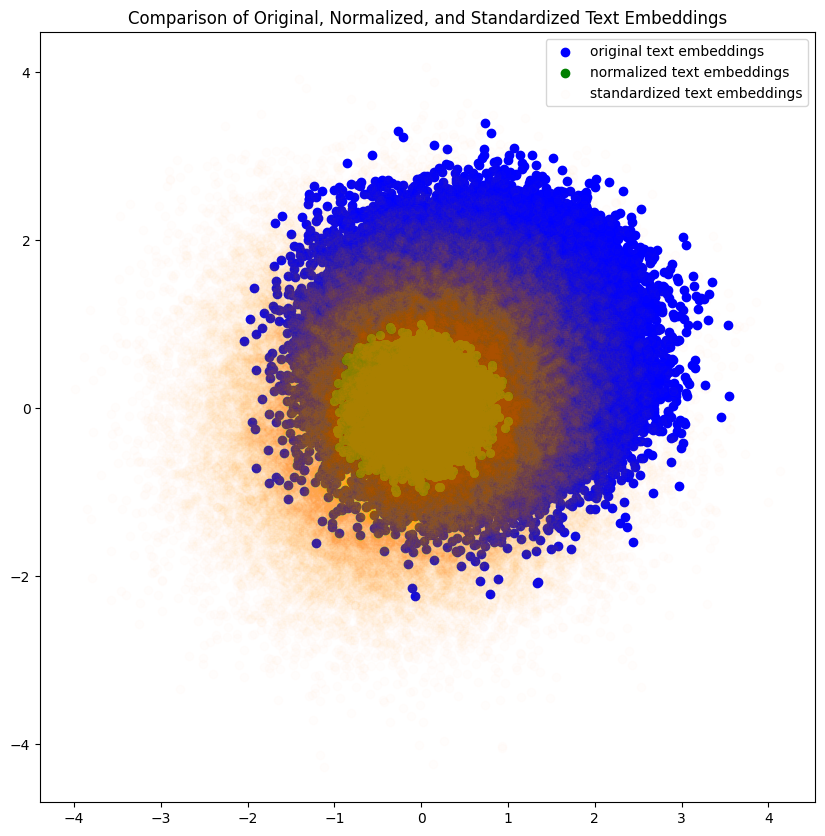

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(X_train[:,952], X_train[:,600], label='original text embeddings', color='blue')
plt.scatter(X_train_norm[:,952], X_train_norm[:,600], alpha=1, label='normalized text embeddings', color='green')
plt.scatter(X_train_scaled[:,952], X_train_scaled[:,600], alpha=0.01, label='standardized text embeddings', color='orange')
plt.legend()
plt.title('Comparison of Original, Normalized, and Standardized Text Embeddings')
plt.show()

*Make Padding*

In [ ]:
# Calculate padding needed
padding_needed = 1536 - 1024  # This is 512

In [ ]:
X_train_scaled = F.pad(X_train_scaled, (0, padding_needed))
X_val_scaled = F.pad(X_val_scaled, (0, padding_needed))

In [ ]:
X_train_scaled.shape, X_val_scaled.shape

(torch.Size([112500, 1536]), torch.Size([12500, 1536]))

# SVD approach

In [ ]:
X_train_scaled.T.shape

torch.Size([1536, 112500])

In [ ]:
y_train_scaled.shape

torch.Size([112500, 1536])

In [ ]:
X_train_scaled

tensor([[-1.0484, -0.2398, -1.1937,  ...,  1.9227, -0.8140,  0.6990],
        [ 0.5970, -1.0902, -1.0971,  ...,  0.5235, -0.6814,  0.5296],
        [-0.8602, -0.6004, -1.7190,  ..., -0.0170,  0.2435, -0.2536],
        ...,
        [ 0.7032, -0.8866, -0.9816,  ..., -0.3574,  1.2990, -1.6193],
        [ 1.9398, -1.4414, -0.8151,  ...,  1.1098,  1.5640, -1.2967],
        [ 0.5412, -1.3856, -2.1370,  ...,  1.5716,  1.2756,  0.0366]])

In [ ]:
# --- 1. Load your pre-processed training data ---
# (Make sure these are the NumPy arrays, not Tensors)
# X_padded shape: (125000, 1536) - Standardized & Padded
# Y_scaled shape: (125000, 1536) - Standardized
# X_padded = ... 
# Y_scaled = ...

print("Calculating SVD (Procrustes) solution...")

# --- 2. Calculate the Covariance Matrix (M) ---
# Shape: (1536, 112500) @ (112500, 1536) -> (1536, 1536)
M = X_train_scaled.T @ y_train_scaled

# --- 3. Perform SVD on M ---
# U and V_transpose (Vt) will be the rotation matrices
# U shape: (1536, 1536)
# Vt shape: (1536, 1536)
U, S, Vt = np.linalg.svd(M)

# # --- 4. Calculate the optimal Translator Matrix (W) ---
# # This is the "Procrustes" solution
W_translator = U @ Vt

# print("SVD Translator matrix 'W' calculated.")

# # --- 5. Save your translator ---
np.save('svd_translator.npy', W_translator)

Calculating SVD (Procrustes) solution...


In [ ]:
# read scaler for features
with open('scaler_X.pkl', 'rb') as f:
    sc_x = pickle.load(f)

# read scaler for targets
with open('scaler_Y.pkl', 'rb') as f:
    sc_y = pickle.load(f)

In [ ]:
# --- Load your pre-processed test data ---
# X_test_padded shape: (N_test, 1536)

test_data = load_data("data/test/test/test.clean.npz")

test_embds = test_data['captions/embeddings']
test_embds = sc_x.transform(test_embds) # Scale the test caption embeddings
test_embds = torch.from_numpy(test_embds).float()
padding_needed = 1536 - 1024  # This is 512
test_embds = F.pad(test_embds, (0, padding_needed)) # make zero padding

# --- Load the translator ---
W_translator = np.load('svd_translator.npy')

# --- Get Predictions ---
# (N_test, 1536) @ (1536, 1536) -> (N_test, 1536)
predicted_Y_scaled = test_embds @ W_translator
predicted_Y_scaled_val = X_val_scaled @ W_translator
predicted_Y_scaled_train = X_train_scaled @ W_translator

# --- Inverse Transform ---
predicted_Y_scaled_inverse = sc_y.inverse_transform(predicted_Y_scaled.numpy())
predicted_Y_scaled_val_inverse = sc_y.inverse_transform(predicted_Y_scaled_val.numpy())
predicted_Y_scaled_train_inverse = sc_y.inverse_transform(predicted_Y_scaled_train.numpy())

# --- This is your submission file ---
# np.save('submission.npy', predicted_Y_scaled)

C:\Users\User\AppData\Local\Temp\ipykernel_21904\3055462687.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  predicted_Y_scaled = test_embds @ W_translator
C:\Users\User\AppData\Local\Temp\ipykernel_21904\3055462687.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  predicted_Y_scaled_val = X_val_scaled @ W_translator
C:\Users\User\AppData\Local\Temp\ipykernel_21904\3055462687.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  predicted_Y_scaled_train = X_train_scaled @ W_translator


In [ ]:
print("Final evaluation on training set (without inverse transform):")
print(evaluate_retrieval(predicted_Y_scaled_train, y_train_scaled, labels_train_indices))

print("Final evaluation on validation set (without inverse transform):")
print(evaluate_retrieval(predicted_Y_scaled_val, y_val_scaled, labels_val_indices))

Final evaluation on training set (without inverse transform):
{'mrr': np.float64(0.8749450266495369), 'ndcg': np.float64(0.9018276680297713), 'recall_at_1': 0.85592, 'recall_at_3': 0.85592, 'recall_at_5': 0.85592, 'recall_at_10': 0.9489155555555555, 'recall_at_50': 0.9982133333333333, 'l2_dist': 50.41200256347656}
Final evaluation on validation set (without inverse transform):
{'mrr': np.float64(0.8375479140185044), 'ndcg': np.float64(0.8721636647915535), 'recall_at_1': 0.81376, 'recall_at_3': 0.81376, 'recall_at_5': 0.81376, 'recall_at_10': 0.92776, 'recall_at_50': 0.99664, 'l2_dist': 50.3546257019043}


In [ ]:
print("Final evaluation on training set (without inverse transform):")
print(evaluate_retrieval(predicted_Y_scaled_train, y_train, labels_train_indices))

print("Final evaluation on validation set (without inverse transform):")
print(evaluate_retrieval(predicted_Y_scaled_val, y_val, labels_val_indices))

Final evaluation on training set (without inverse transform):
{'mrr': np.float64(0.8715005682518561), 'ndcg': np.float64(0.899066479754387), 'recall_at_1': 0.8521333333333333, 'recall_at_3': 0.8521333333333333, 'recall_at_5': 0.8521333333333333, 'recall_at_10': 0.9462933333333333, 'recall_at_50': 0.9980711111111111, 'l2_dist': 41.16220474243164}
Final evaluation on validation set (without inverse transform):
{'mrr': np.float64(0.8354459077313924), 'ndcg': np.float64(0.8704508432540425), 'recall_at_1': 0.8116, 'recall_at_3': 0.8116, 'recall_at_5': 0.8116, 'recall_at_10': 0.9244, 'recall_at_50': 0.9964, 'l2_dist': 41.15120315551758}


In [ ]:
print("Final evaluation on training set (inverse transform):")
print(evaluate_retrieval(predicted_Y_scaled_train_inverse, y_train, labels_train_indices))

print("Final evaluation on validation set (inverse transform):")
print(evaluate_retrieval(predicted_Y_scaled_val_inverse, y_val, labels_val_indices))

Final evaluation on training set (inverse transform):
{'mrr': np.float64(0.8686485388691961), 'ndcg': np.float64(0.8967819939932168), 'recall_at_1': 0.8489955555555555, 'recall_at_3': 0.8489955555555555, 'recall_at_5': 0.8489955555555555, 'recall_at_10': 0.9441777777777778, 'recall_at_50': 0.9979555555555556, 'l2_dist': 31.850875854492188}
Final evaluation on validation set (inverse transform):
{'mrr': np.float64(0.8331508379036706), 'ndcg': np.float64(0.868657813483733), 'recall_at_1': 0.80888, 'recall_at_3': 0.80888, 'recall_at_5': 0.80888, 'recall_at_10': 0.9244, 'recall_at_50': 0.99632, 'l2_dist': 31.819059371948242}


In [ ]:
submission = generate_submission(test_data['captions/ids'], predicted_Y_scaled_inverse, 'submissions/submission_svd_denormalized.csv')

Generating submission file...
✓ Saved submission to submissions/submission_svd_denormalized.csv


# Model Training

In [ ]:
# Configuration
MODEL_PATH = "models/mlp_v1.pth"
EPOCHS = 20
BATCH_SIZE = 256
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
class MLP(nn.Module):
    def __init__(self, input_dim=1536, output_dim=1536, hidden_dim=2048):
        super().__init__()
        self.net = nn.Sequential(
            # nn.Linear(input_dim, output_dim),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# Initialize model
model = MLP().to(DEVICE)
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")


train_loader = DataLoader(TensorDataset(X_train_scaled, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_scaled, y_val), batch_size=BATCH_SIZE)
X_train_scaled.shape, X_val_scaled.shape

# Train
print("\n3. Training...")
model = train_model(model, train_loader, val_loader, DEVICE, EPOCHS, LR, MODEL_PATH)

# Load best model for evaluation
model.load_state_dict(torch.load(MODEL_PATH))

   Parameters: 6,295,040

3. Training...


Epoch 1/20: 100%|██████████| 440/440 [00:35<00:00, 12.30it/s]


Epoch 1: Train Loss = 0.155099, Val Loss = 0.150115
  ✓ Saved best model (val_loss=0.150115)


Epoch 2/20: 100%|██████████| 440/440 [00:49<00:00,  8.86it/s]


Epoch 2: Train Loss = 0.143359, Val Loss = 0.147338
  ✓ Saved best model (val_loss=0.147338)


Epoch 3/20: 100%|██████████| 440/440 [00:42<00:00, 10.42it/s]


Epoch 3: Train Loss = 0.139890, Val Loss = 0.145687
  ✓ Saved best model (val_loss=0.145687)


Epoch 4/20: 100%|██████████| 440/440 [00:39<00:00, 11.12it/s]


Epoch 4: Train Loss = 0.137485, Val Loss = 0.145248
  ✓ Saved best model (val_loss=0.145248)


Epoch 5/20: 100%|██████████| 440/440 [00:40<00:00, 10.89it/s]


Epoch 5: Train Loss = 0.135426, Val Loss = 0.144707
  ✓ Saved best model (val_loss=0.144707)


Epoch 6/20: 100%|██████████| 440/440 [00:43<00:00, 10.21it/s]


Epoch 6: Train Loss = 0.133618, Val Loss = 0.144191
  ✓ Saved best model (val_loss=0.144191)


Epoch 7/20: 100%|██████████| 440/440 [00:35<00:00, 12.40it/s]


Epoch 7: Train Loss = 0.131914, Val Loss = 0.144025
  ✓ Saved best model (val_loss=0.144025)


Epoch 8/20: 100%|██████████| 440/440 [00:32<00:00, 13.43it/s]


Epoch 8: Train Loss = 0.130419, Val Loss = 0.144089


Epoch 9/20: 100%|██████████| 440/440 [00:32<00:00, 13.67it/s]


Epoch 9: Train Loss = 0.128988, Val Loss = 0.144036


Epoch 10/20: 100%|██████████| 440/440 [00:31<00:00, 14.06it/s]


Epoch 10: Train Loss = 0.127614, Val Loss = 0.144009
  ✓ Saved best model (val_loss=0.144009)


Epoch 11/20: 100%|██████████| 440/440 [00:31<00:00, 13.78it/s]


Epoch 11: Train Loss = 0.126366, Val Loss = 0.144255


Epoch 12/20: 100%|██████████| 440/440 [00:31<00:00, 13.83it/s]


Epoch 12: Train Loss = 0.125086, Val Loss = 0.144491


Epoch 13/20: 100%|██████████| 440/440 [00:38<00:00, 11.33it/s]


Epoch 13: Train Loss = 0.123935, Val Loss = 0.144613


Epoch 14/20: 100%|██████████| 440/440 [01:18<00:00,  5.63it/s]


Epoch 14: Train Loss = 0.122755, Val Loss = 0.145130


Epoch 15/20: 100%|██████████| 440/440 [00:32<00:00, 13.34it/s]


Epoch 15: Train Loss = 0.121673, Val Loss = 0.145207


Epoch 16/20: 100%|██████████| 440/440 [00:32<00:00, 13.42it/s]


Epoch 16: Train Loss = 0.120605, Val Loss = 0.145296


Epoch 17/20: 100%|██████████| 440/440 [00:33<00:00, 13.18it/s]


Epoch 17: Train Loss = 0.119607, Val Loss = 0.145779


Epoch 18/20: 100%|██████████| 440/440 [00:34<00:00, 12.77it/s]


Epoch 18: Train Loss = 0.118585, Val Loss = 0.146121


Epoch 19/20: 100%|██████████| 440/440 [00:34<00:00, 12.80it/s]


Epoch 19: Train Loss = 0.117617, Val Loss = 0.146234


Epoch 20/20: 100%|██████████| 440/440 [00:34<00:00, 12.79it/s]


Epoch 20: Train Loss = 0.116763, Val Loss = 0.146683


<All keys matched successfully>

# Generate Submission

In [ ]:
# read scaler for features
with open('scaler_X.pkl', 'rb') as f:
    sc_x = pickle.load(f)

# read scaler for targets
with open('scaler_Y.pkl', 'rb') as f:
    sc_y = pickle.load(f)

In [ ]:
# Load best model for evaluation
model = MLP().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [ ]:
test_data = load_data("data/test/test/test.clean.npz")

test_embds = test_data['captions/embeddings']
test_embds = sc_x.transform(test_embds) # Scale the test caption embeddings
test_embds = torch.from_numpy(test_embds).float()
padding_needed = 1536 - 1024  # This is 512
test_embds = F.pad(test_embds, (0, padding_needed)) # make zero padding

with torch.no_grad():
    pred_embds = model(test_embds.to(DEVICE)).cpu()
    pred_embds_val = model(X_val_scaled.to(DEVICE)).cpu()
    pred_embds_train = model(X_train_scaled.to(DEVICE)).cpu()

# submission = generate_submission(test_data['captions/ids'], pred_embds, 'submissions/submission_v1.csv')
# print(f"Model saved to: {MODEL_PATH}")

In [ ]:
pred_embds_inversed = torch.from_numpy(sc_y.inverse_transform(pred_embds)).float()
pred_embds_val_inversed = torch.from_numpy(sc_y.inverse_transform(pred_embds_val)).float()
pred_embds_train_inversed = torch.from_numpy(sc_y.inverse_transform(pred_embds_train)).float()

In [ ]:
StandardScaler().fit_transform(pred_embds).mean()#.mean(axis=1)

np.float64(-1.6576246548222822e-20)

In [ ]:
pred_embds.mean()#.mean(axis=1)

tensor(1.8557e-05)

In [ ]:
submission = generate_submission(test_data['captions/ids'], StandardScaler().fit_transform(pred_embds), 'submissions/submission_v10.csv')
print(f"Model saved to: {MODEL_PATH}")

Generating submission file...
✓ Saved submission to submissions/submission_v10.csv
Model saved to: models/mlp_v1.pth


# Evaluation

In [ ]:
print("Final evaluation on training set:")
print(evaluate_retrieval(pred_embds_train_inversed, y_train, labels_train_indices))

print("Final evaluation on validation set:")
print(evaluate_retrieval(pred_embds_val_inversed, y_val, labels_val_indices))

Final evaluation on training set:
{'mrr': np.float64(0.8400417776251033), 'ndcg': np.float64(0.8736264769635009), 'recall_at_1': 0.8181422222222222, 'recall_at_3': 0.8181422222222222, 'recall_at_5': 0.8181422222222222, 'recall_at_10': 0.9190311111111111, 'recall_at_50': 0.9948977777777778, 'l2_dist': 19.781431198120117}
Final evaluation on validation set:
{'mrr': np.float64(0.7459573692604734), 'ndcg': np.float64(0.7981046943350703), 'recall_at_1': 0.71472, 'recall_at_3': 0.71472, 'recall_at_5': 0.71472, 'recall_at_10': 0.84904, 'recall_at_50': 0.98632, 'l2_dist': 19.66731071472168}


In [ ]:
print("Final evaluation on training set:")
print(evaluate_retrieval(pred_embds_train, y_train, labels_train_indices))

print("Final evaluation on validation set:")
print(evaluate_retrieval(pred_embds_val, y_val, labels_val_indices))

Final evaluation on training set:
{'mrr': np.float64(0.9217661535441259), 'ndcg': np.float64(0.93890643335934), 'recall_at_1': 0.9087555555555555, 'recall_at_3': 0.9087555555555555, 'recall_at_5': 0.9087555555555555, 'recall_at_10': 0.9763377777777777, 'recall_at_50': 0.9996533333333333, 'l2_dist': 33.91739273071289}
Final evaluation on validation set:
{'mrr': np.float64(0.8509497813398018), 'ndcg': np.float64(0.8829141404885074), 'recall_at_1': 0.82856, 'recall_at_3': 0.82856, 'recall_at_5': 0.82856, 'recall_at_10': 0.93672, 'recall_at_50': 0.998, 'l2_dist': 33.63210678100586}


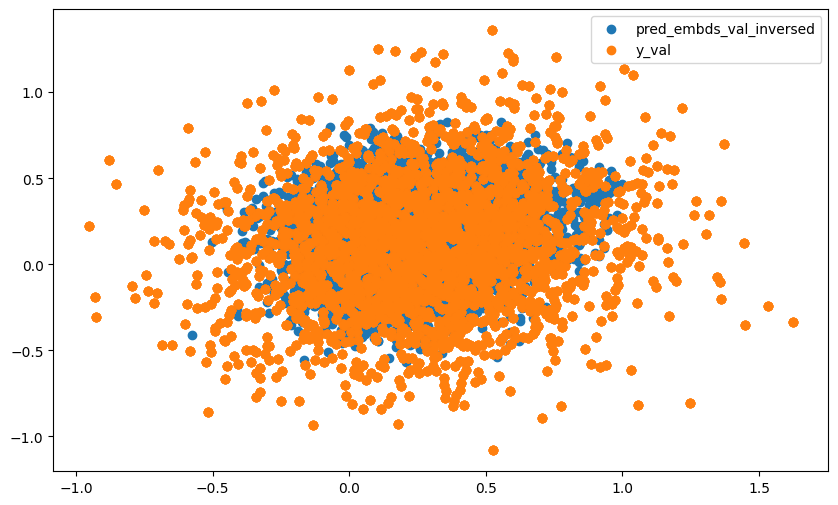

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(pred_embds_val_inversed[:,100], pred_embds_val_inversed[:,1], label='pred_embds_val_inversed')
plt.scatter(y_val[:,100], y_val[:,1], label='y_val')
plt.legend()

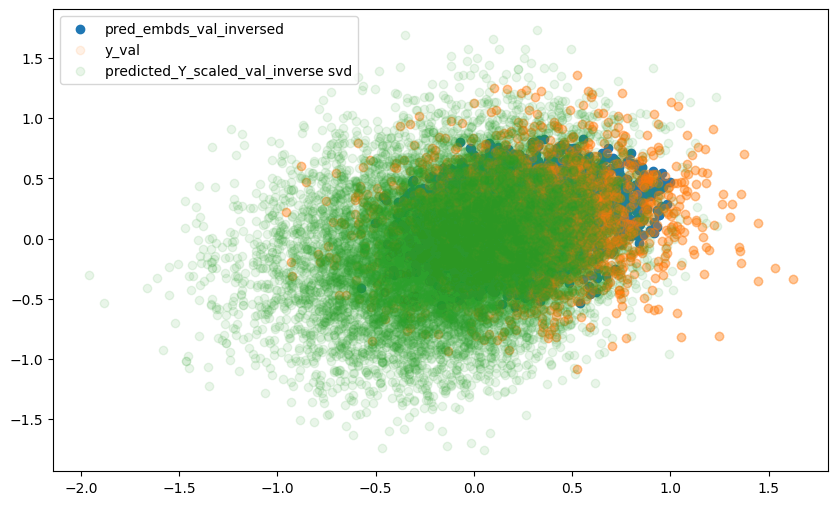

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(pred_embds_val_inversed[:,100], pred_embds_val_inversed[:,1], label='pred_embds_val_inversed')
plt.scatter(y_val[:,100], y_val[:,1], label='y_val', alpha=0.1)
plt.scatter(predicted_Y_scaled_val_inverse[:,100], predicted_Y_scaled_val_inverse[:,1], label='predicted_Y_scaled_val_inverse svd', alpha=0.1)
plt.legend()

# Anchors Strategy

In [ ]:
# from sklearn.cluster import KMeans

# def select_anchors(X, Y, n_anchors=1000, method='diverse'):
#     """
#     Select anchor points for semantic alignment
    
#     Parameters:
#     - X: source embeddings (text)
#     - Y: target embeddings (vision) 
#     - n_anchors: number of anchor points (paper uses 500-2000)
#     - method: 'random' or 'diverse' (k-means based)
#     """
    
#     if method == 'random':
#         # Simple random selection (baseline)
#         indices = np.random.choice(len(X), n_anchors, replace=False)
        
#     elif method == 'diverse':
#         # K-means based selection (covers data distribution better)
#         # Paper doesn't specify method, but diverse anchors work better
#         kmeans = KMeans(n_clusters=n_anchors, random_state=42, n_init=10)
#         kmeans.fit(X)
        
#         # Find closest points to centroids
#         distances = np.linalg.norm(X[:, np.newaxis] - kmeans.cluster_centers_, axis=2)
#         indices = np.argmin(distances, axis=0)
    
#     return X[indices], Y[indices], indices

# # Usage:
# X_anchors, Y_anchors, anchor_indices = select_anchors(
#     X_train.numpy(),  # Your original text embeddings (not scaled yet)
#     y_train.numpy(),  # Your original vision embeddings
#     n_anchors=1000,
#     method='diverse'
# )

In [ ]:
def improved_anchor_svd(X_train, y_train, X_val, y_val, n_anchors=5000):
    """Use more anchors - paper shows performance improves with more anchors"""
    print(f"Using {n_anchors} anchors (instead of 1000)")
    
    # Use your original working SVD approach but on anchor subset
    indices = np.random.choice(len(X_train), n_anchors, replace=False)
    X_anchors = X_train.numpy()[indices]
    y_anchors = y_train.numpy()[indices]
    
    # Standard scaling (fit on anchors, apply to all)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    scaler_X.fit(X_anchors)
    scaler_y.fit(y_anchors)
    
    X_anchors_scaled = scaler_X.transform(X_anchors)
    y_anchors_scaled = scaler_y.transform(y_anchors)
    X_val_scaled = scaler_X.transform(X_val.numpy())
    
    # Zero padding
    X_anchors_padded = np.pad(X_anchors_scaled, ((0,0), (0,512)), 'constant')
    X_val_padded = np.pad(X_val_scaled, ((0,0), (0,512)), 'constant')
    
    # SVD on anchors
    M = X_anchors_padded.T @ y_anchors_scaled
    U, S, Vt = np.linalg.svd(M, full_matrices=True)
    R = U @ Vt
    
    # Predict
    y_val_pred_scaled = X_val_padded @ R
    
    # Evaluate against scaled ground truth
    y_val_scaled = scaler_y.transform(y_val.numpy())
    # y_val_pred_scaled_inversed = scaler_y.inverse_transform(y_val_pred_scaled)
    results = evaluate_retrieval(y_val_pred_scaled, y_val_scaled, labels_val_indices)
    
    return results, R, scaler_X, scaler_y

# Try with more anchors
for n_anchors in [5000, 10000, 20000]:
    results, R, scaler_X, scaler_y = improved_anchor_svd(X_train, y_train, X_val, y_val, n_anchors)
    print(f"Anchors: {n_anchors}, MRR: {results['mrr']:.4f}")

Using 5000 anchors (instead of 1000)
Anchors: 5000, MRR: 0.8090
Using 10000 anchors (instead of 1000)
Anchors: 10000, MRR: 0.8217
Using 20000 anchors (instead of 1000)
Anchors: 20000, MRR: 0.8284


In [ ]:
nn.Parameter(torch.tensor(2.6592))

Parameter containing:
tensor(2.6592, requires_grad=True)

In [ ]:
import numpy as np
p1 = np.array([-0.83483301, -0.16904167, 0.52390721])
p2 = np.array([-0.83455951, -0.16862266, 0.52447767])
neg = np.array([
 [ 0.70374682, -0.18682394, -0.68544673],
 [ 0.15465702,  0.32303224,  0.93366556],
 [ 0.53043332, -0.83523217, -0.14500935],
 [ 0.68285685, -0.73054075,  0.00409143],
 [ 0.76652431,  0.61500886,  0.18494479]])

In [ ]:
np.linalg.norm(p1)

np.float64(1.0000000027360165)

In [ ]:
np.linalg.norm(neg, axis=1)

array([1., 1., 1., 1., 1.])

In [ ]:
# P1 and p2 are nearly identically, thus close to 1.0
pos_dot = p1.dot(p2)
# pos_dot -> 0.999999716600668
# Most of the negatives are pretty far away, so small or negative
num_neg = len(neg)
neg_dot = np.zeros(num_neg)
for i in range(num_neg):
    neg_dot[i] = p1.dot(neg[i])
# neg_dot -> [-0.91504053,  0.30543542, -0.37760565, -0.44443608, -0.64698801]

In [ ]:
pos_dot, neg_dot

(np.float64(0.999999716600668),
 array([-0.91504053,  0.30543542, -0.37760565, -0.44443608, -0.64698801]))

In [ ]:
# Contrastive loss of the example values
# temp parameter
t = 0.07
# concatenated vector divided by the temp parameter
logits = np.concatenate(([pos_dot], neg_dot))/t
#e^x of the values
exp = np.exp(logits)
# we only need to take the log of the positive value over the sum of exp. 
loss = - np.log(exp[0]/np.sum(exp))

In [ ]:
logits

array([ 14.28571024, -13.07200756,   4.3633632 ,  -5.3943664 ,
        -6.34908688,  -9.2426859 ])

In [ ]:
exp

array([1.60031371e+06, 2.10329045e-06, 7.85207716e+01, 4.54209734e-03,
       1.74834286e-03, 9.68171997e-05])

In [ ]:
exp[0]

np.float64(1600313.7106582962)

In [ ]:
torch.tensor([[1,2,3],[4,5,6]]).float()

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [ ]:
np.linalg.norm(torch.tensor([[1,2,3],[4,5,6]]).float(), axis=1)

array([3.7416575, 8.774964 ], dtype=float32)

In [ ]:
np.linalg.norm(F.normalize(torch.tensor([[1,2,3],[4,5,6]]).float(), dim=1, p=2), axis=1)

array([0.99999994, 1.        ], dtype=float32)

In [ ]:
torch.arange(20)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])

In [28]:
torch.tensor([0.9, 0.2, 0.1, 0.3]).softmax(dim=0)

tensor([0.4008, 0.1991, 0.1801, 0.2200])

In [ ]:
torch.tensor([9, 2, 1, 3]).float().softmax(dim=0)s

tensor([9.9629e-01, 9.0850e-04, 3.3422e-04, 2.4696e-03])

In [ ]:
torch.tensor([9, 2, 1, 3]).float().softmax(dim=0)[1]

tensor(0.0009)

In [10]:
import torch

In [11]:
label_indices = torch.tensor([0, 0, 0, 1, 1, 1])  

In [12]:
label_indices

tensor([0, 0, 0, 1, 1, 1])

In [13]:
label_indices.unsqueeze(1)

tensor([[0],
        [0],
        [0],
        [1],
        [1],
        [1]])

In [14]:
label_indices.unsqueeze(0)

tensor([[0, 0, 0, 1, 1, 1]])

In [16]:
(label_indices.unsqueeze(1) == label_indices.unsqueeze(0)).float()

tensor([[1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.]])